### Projet 6 : Implémentez un modèle de scoring
    
L'objectif est de développer un modèle de scoring de la probabilité de défaut de paiement d'un client pour étayer la décision d'accorder ou non un prêt à un client potentiel

Les données sont plusieurs fichiers '.csv' qui renseignent des informations concernant les clients d'une banque.

Le fichier 'application_train' donne de multiples informations sur des clients qui ont effectué un emprunt ainsi que la mention remboursé ou défaut de payement sur cet emprunt.

Le fichier application_test renseigne exactement les mêmes informations que le fichier 'application_train', mais il s'agit de déterminer la probabilité de défaut de paiement pour ces nouveaux emprunts.

Quant aux autres fichiers il s'agit d'informations relatives à des emprunts antérieurs qui ont été accordés soit par d'autres institutions soit par la même banque.

L'organigramme ci-dessous présente l'ensemble des fichiers à notre disposition, leur contenu ansi que les liens qui les relient.


Les données sont disponibles à l'adresse suivante : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip

Cette partie est décomposé en 3 sous parties.

La première partie est une brève description des données 'application_train/test'.

Pour chaque variable numérique des jeux de données, il y a des informations concernant le pourcentage de données manquantes, la moyenne, la médianne, l'écart-type etc...
Pour chaque variable catégorielle, il y a des informations concernant les données manquantes et pour chaque valeur prise par la variable il y a le nombre d'occurences
La deuxième partie s'intéresse au nettoyage des données.

Les individus dont les valeurs des variables catégorielles sont non communes aux jeux test et d'entrainement sont supprimés ainsi que les individus dont les valeurs trop peu fréquentes
Les valeurs abérrantes de certaines variables numériques sont remplacés par 'NaN' pour une imputation ultérieure

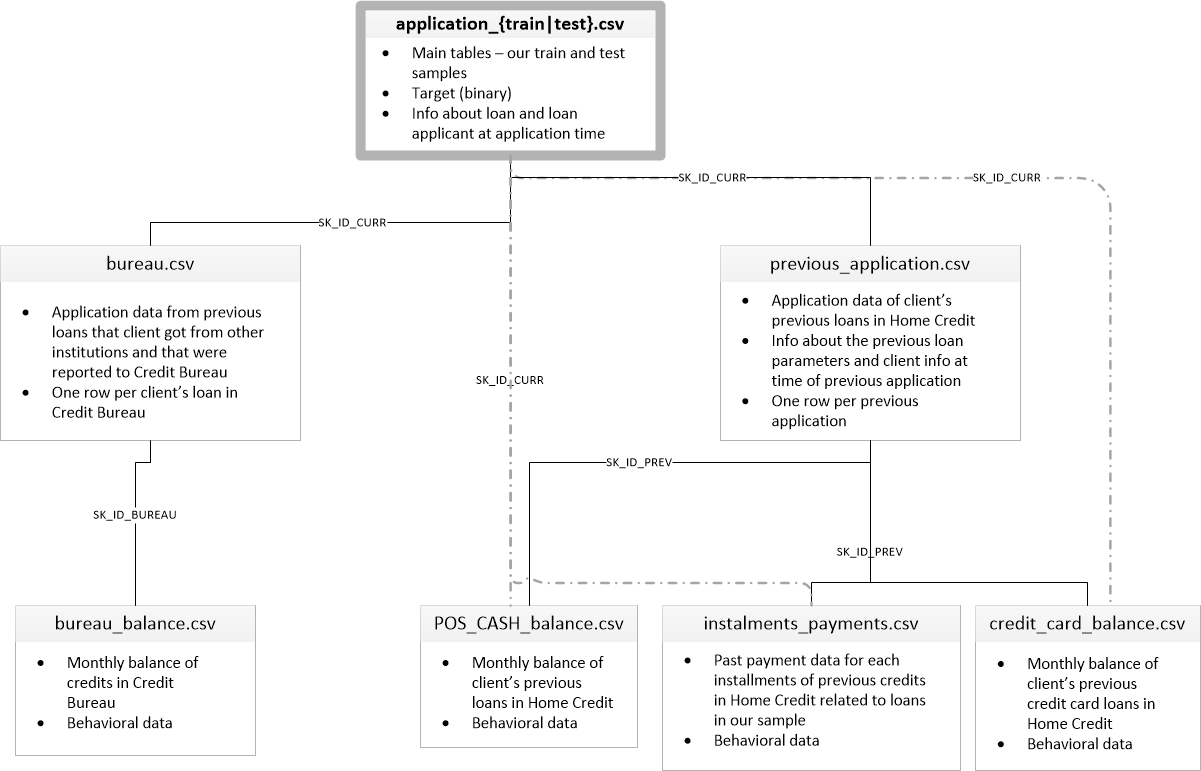

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif

from os import listdir
from os.path import isfile, join

import cv2


# Feature engineering
import featuretools as ft

# Feature engineering
import featuretools as ft
from featuretools import selection


# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [2]:
# Lecture des données
train_set = pd.read_csv('application_train.csv').sort_values("SK_ID_CURR")
test_set = pd.read_csv('application_test.csv').sort_values("SK_ID_CURR")
bureau = pd.read_csv("bureau.csv").sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])
bureau_balance = pd.read_csv("bureau_balance.csv").sort_values("SK_ID_BUREAU")
cash_balance = pd.read_csv("POS_CASH_balance.csv").sort_values([
    'SK_ID_CURR', 'SK_ID_PREV'])
card_balance = pd.read_csv('credit_card_balance.csv')
prev_app = pd.read_csv('previous_application.csv').sort_values(
    ['SK_ID_CURR', 'SK_ID_PREV'])
payments = pd.read_csv('installments_payments.csv').sort_values(
    ['SK_ID_CURR', 'SK_ID_PREV'])

In [3]:
# Chargement des fichiers csv dans une liste de dataframes

mypath=r"C:\Users\viault\Desktop\données7"
files = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]

df = np.empty(len(files), dtype=object)

for n in range(0, len(files)):
    df[n] = pd.read_csv(join(mypath,files[n]), encoding = 'unicode_escape')

print("Il y a {} fichiers dans le dossier".format(len(df)))

Il y a 10 fichiers dans le dossier


In [81]:
# Affichage des noms des fichiers

for i in range(len(df)):
    print("df[{}] contient le fichier: {}".format(i, files[i]))

df[0] contient le fichier: application_test.csv
df[1] contient le fichier: application_train.csv
df[2] contient le fichier: bureau.csv
df[3] contient le fichier: bureau_balance.csv
df[4] contient le fichier: credit_card_balance.csv
df[5] contient le fichier: HomeCredit_columns_description.csv
df[6] contient le fichier: installments_payments.csv
df[7] contient le fichier: POS_CASH_balance.csv
df[8] contient le fichier: previous_application.csv
df[9] contient le fichier: sample_submission.csv


In [4]:
df[1].shape

(307511, 122)

In [5]:
df[0].shape

(48744, 121)

### Dataframe principal training & testing sets

In [8]:
# Analyse des tailles respectives

print("Taille du Df de training: {} \
    \n Taille du Df de testing: {}".format(train_set.shape, test_set.shape))

Taille du Df de training: (307511, 122)     
 Taille du Df de testing: (48744, 121)


In [9]:
# Affiche les 5 premières lignes des données d'entrainement
train_set.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
def describe_columns_df(df):
    """
    Affiche la description détaillée du contenu de chaque colonne de df
    df(pd.Dataframe): jeu de données
    """
    for col in df:
        print(col)
        null = df[col].isnull().sum()
        # affiche le nombre de valeurs manquantes
        print('Number of empty : ', null)
        # affiche le pourcentage de valeurs manquantes
        print('Percent of empty : ', 100*null/df.shape[0])
        print(df[col].describe())
        if df[col].dtype == object:
            print('Categories and Count:')
            print(df[col].value_counts().to_string(header=None))
        print('\n')

In [11]:
# Affiche la description détaillée du contenu
# de chaque colonne du jeu d'entrainement
describe_columns_df(train_set)

SK_ID_CURR
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean     278180.518577
std      102790.175348
min      100002.000000
25%      189145.500000
50%      278202.000000
75%      367142.500000
max      456255.000000
Name: SK_ID_CURR, dtype: float64


TARGET
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64


NAME_CONTRACT_TYPE
Number of empty :  0
Percent of empty :  0.0
count         307511
unique             2
top       Cash loans
freq          278232
Name: NAME_CONTRACT_TYPE, dtype: object
Categories and Count:
Cash loans         278232
Revolving loans     29279


CODE_GENDER
Number of empty :  0
Percent of empty :  0.0
count     307511
unique         3
top            F
freq      202448
Name: CODE_GENDER, dtype: object
Categories and Count:
F      202448


Number of empty :  96391
Percent of empty :  31.345545362604916
count       211120
unique          18
top       Laborers
freq         55186
Name: OCCUPATION_TYPE, dtype: object
Categories and Count:
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526


CNT_FAM_MEMBERS
Number of empty :  2
Percent of empty :  0.000650383238323182
count    307509.000000
mean          2.152665
std           0.910682
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
ma

Name: ELEVATORS_AVG, dtype: float64


ENTRANCES_AVG
Number of empty :  154828
Percent of empty :  50.34876801155081
count    152683.000000
mean          0.149725
std           0.100049
min           0.000000
25%           0.069000
50%           0.137900
75%           0.206900
max           1.000000
Name: ENTRANCES_AVG, dtype: float64


FLOORSMAX_AVG
Number of empty :  153020
Percent of empty :  49.76082156410665
count    154491.000000
mean          0.226282
std           0.144641
min           0.000000
25%           0.166700
50%           0.166700
75%           0.333300
max           1.000000
Name: FLOORSMAX_AVG, dtype: float64


FLOORSMIN_AVG
Number of empty :  208642
Percent of empty :  67.84862980511267
count    98869.000000
mean         0.231894
std          0.161380
min          0.000000
25%          0.083300
50%          0.208300
75%          0.375000
max          1.000000
Name: FLOORSMIN_AVG, dtype: float64


LANDAREA_AVG
Number of empty :  182590
Percent of empty :  59.37673774



ENTRANCES_MEDI
Number of empty :  154828
Percent of empty :  50.34876801155081
count    152683.000000
mean          0.149213
std           0.100368
min           0.000000
25%           0.069000
50%           0.137900
75%           0.206900
max           1.000000
Name: ENTRANCES_MEDI, dtype: float64


FLOORSMAX_MEDI
Number of empty :  153020
Percent of empty :  49.76082156410665
count    154491.000000
mean          0.225897
std           0.145067
min           0.000000
25%           0.166700
50%           0.166700
75%           0.333300
max           1.000000
Name: FLOORSMAX_MEDI, dtype: float64


FLOORSMIN_MEDI
Number of empty :  208642
Percent of empty :  67.84862980511267
count    98869.000000
mean         0.231625
std          0.161934
min          0.000000
25%          0.083300
50%          0.208300
75%          0.375000
max          1.000000
Name: FLOORSMIN_MEDI, dtype: float64


LANDAREA_MEDI
Number of empty :  182590
Percent of empty :  59.376737742714894
count    124921.00000

Name: FLAG_DOCUMENT_11, dtype: float64


FLAG_DOCUMENT_12
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.000007
std           0.002550
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_12, dtype: float64


FLAG_DOCUMENT_13
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.003525
std           0.059268
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_13, dtype: float64


FLAG_DOCUMENT_14
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.002936
std           0.054110
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_14, dtype: float64


FLAG_DOCUMENT_15
Number of empty :  0
Percent of empty :  0.0
count    307511.00000
mean          

In [12]:
# Affiche les 5 premières lignes des données de test
test_set.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN



La différence entre les 2 dataframes s'expliquent par la présence de la colonne TARGET qui représente ce que nous devons prédire (défaut ou pas sur un prêt). Je le vérifie rapidement.

In [13]:
test_set.shape

(48744, 121)

In [14]:
# Affiche la description détaillée du contenu de chaque colonne du jeu test
describe_columns_df(test_set)

SK_ID_CURR
Number of empty :  0
Percent of empty :  0.0
count     48744.000000
mean     277796.676350
std      103169.547296
min      100001.000000
25%      188557.750000
50%      277549.000000
75%      367555.500000
max      456250.000000
Name: SK_ID_CURR, dtype: float64


NAME_CONTRACT_TYPE
Number of empty :  0
Percent of empty :  0.0
count          48744
unique             2
top       Cash loans
freq           48305
Name: NAME_CONTRACT_TYPE, dtype: object
Categories and Count:
Cash loans         48305
Revolving loans      439


CODE_GENDER
Number of empty :  0
Percent of empty :  0.0
count     48744
unique        2
top           F
freq      32678
Name: CODE_GENDER, dtype: object
Categories and Count:
F    32678
M    16066


FLAG_OWN_CAR
Number of empty :  0
Percent of empty :  0.0
count     48744
unique        2
top           N
freq      32311
Name: FLAG_OWN_CAR, dtype: object
Categories and Count:
N    32311
Y    16433


FLAG_OWN_REALTY
Number of empty :  0
Percent of empty :  0.0


SUNDAY       1859


HOUR_APPR_PROCESS_START
Number of empty :  0
Percent of empty :  0.0
count    48744.000000
mean        12.007365
std          3.278172
min          0.000000
25%         10.000000
50%         12.000000
75%         14.000000
max         23.000000
Name: HOUR_APPR_PROCESS_START, dtype: float64


REG_REGION_NOT_LIVE_REGION
Number of empty :  0
Percent of empty :  0.0
count    48744.000000
mean         0.018833
std          0.135937
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: REG_REGION_NOT_LIVE_REGION, dtype: float64


REG_REGION_NOT_WORK_REGION
Number of empty :  0
Percent of empty :  0.0
count    48744.000000
mean         0.055166
std          0.228306
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: REG_REGION_NOT_WORK_REGION, dtype: float64


LIVE_REGION_NOT_WORK_REGION
Number of empty :  0
Percent of empty :  0.0
count    48744.0

Number of empty :  27641
Percent of empty :  56.7064664368948
count    21103.000000
mean         0.088998
std          0.082655
min          0.000000
25%          0.042500
50%          0.077000
75%          0.113550
max          1.000000
Name: BASEMENTAREA_MODE, dtype: float64


YEARS_BEGINEXPLUATATION_MODE
Number of empty :  22856
Percent of empty :  46.88987362547185
count    25888.000000
mean         0.978292
std          0.053782
min          0.000000
25%          0.976200
50%          0.981600
75%          0.986600
max          1.000000
Name: YEARS_BEGINEXPLUATATION_MODE, dtype: float64


YEARS_BUILD_MODE
Number of empty :  31818
Percent of empty :  65.27572624322994
count    16926.000000
mean         0.758327
std          0.110117
min          0.000000
25%          0.692900
50%          0.758300
75%          0.823600
max          1.000000
Name: YEARS_BUILD_MODE, dtype: float64


COMMONAREA_MODE
Number of empty :  33495
Percent of empty :  68.71614967996061
count    15249.000000
m

Percent of empty :  46.41391761037256
count    26120.000000
mean         0.107129
std          0.111420
min          0.000000
25%          0.043200
50%          0.070700
75%          0.135700
max          1.000000
Name: TOTALAREA_MODE, dtype: float64


WALLSMATERIAL_MODE
Number of empty :  23893
Percent of empty :  49.017314951583785
count     24851
unique        7
top       Panel
freq      11269
Name: WALLSMATERIAL_MODE, dtype: object
Categories and Count:
Panel           11269
Stone, brick    10434
Block            1428
Wooden            794
Mixed             353
Monolithic        289
Others            284


EMERGENCYSTATE_MODE
Number of empty :  22209
Percent of empty :  45.56253077301822
count     26535
unique        2
top          No
freq      26179
Name: EMERGENCYSTATE_MODE, dtype: object
Categories and Count:
No     26179
Yes      356


OBS_30_CNT_SOCIAL_CIRCLE
Number of empty :  29
Percent of empty :  0.05949450188741178
count    48715.000000
mean         1.447644
std          

### Variable 'TARGET'

La nom de la colonne dont on cherche à prédire la valeur est "TARGET".

La variable prend soit la valeur 0 quand le prêt a été remboursé sans soucis, soit la valeur 1 quand il y a eu un défaut de payement

In [27]:
def solvability_clients(df):
    """
    Pieplot de la solvabilité clients
    df(pd.DataFrame): jeu de données
    """
    # % de valeurs 'TARGET' différentes
    target_values = df['TARGET'].value_counts()/len(df)*100
    # Pieplot du % de chaque valeurs différentes de 'TARGET'
    plt.pie(target_values,
            colors=['#CCFFFF', '#FF0080'],
            autopct='%1.1f%%',
            labels=["Solvable", "Non Solvable"],
            startangle=45)
    #plt.savefig("TypeSup1.png", dpi = 200)
    plt.show()

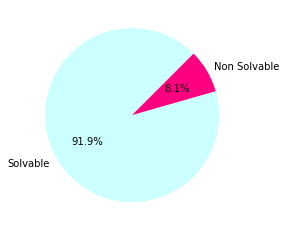

In [28]:
# Pieplot solvabilité clients du jeu d'entrainement
solvability_clients(train_set)


La variable cible est clairement déséquilibrée, 92% des prêts ayant une valeur cible à zéro indiquant que les prêts de ces individus ont été remboursés à temps. Seulement 25000 prêts concernent des emprunteurs ayant eu des difficultés dans les remboursements

### Nettoyage des données


Dans cette partie, les jeu de données d'entrainement et de test sont concaténés pour traiter les features de manière conjointe

In [29]:
def merge_train_test(df_train, df_test):
    """
    Merge les jeu d'entrainement et de test en rajoutant
    une colonne 'Test' qui prend les valeurs True ou False
    df_train(pd.DataFrame): jeu d'entrainement
    df_test(pd.DataFrame): jeu test
    """

    df_train['Test'] = False
    df_test['Test'] = True
    df_test['TARGET'] = np.nan
    app = train_set.append(test_set,
                           ignore_index=True,
                           sort=False)
    return app

In [30]:
# Merge jeu d'entrainement et jeu de test
app = merge_train_test(train_set, test_set)

In [31]:
app

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
356251,456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True
356252,456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,True
356253,456224,NaN,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,True


### Analyse des Valeurs manquantes

In [32]:
# Nombre de colonnes ayant des valeurs manquantes

print("Nombre de colonnes ayant au moins 1 valeur manquante:", len(app.isna().any()[lambda x: x]))

Nombre de colonnes ayant au moins 1 valeur manquante: 68


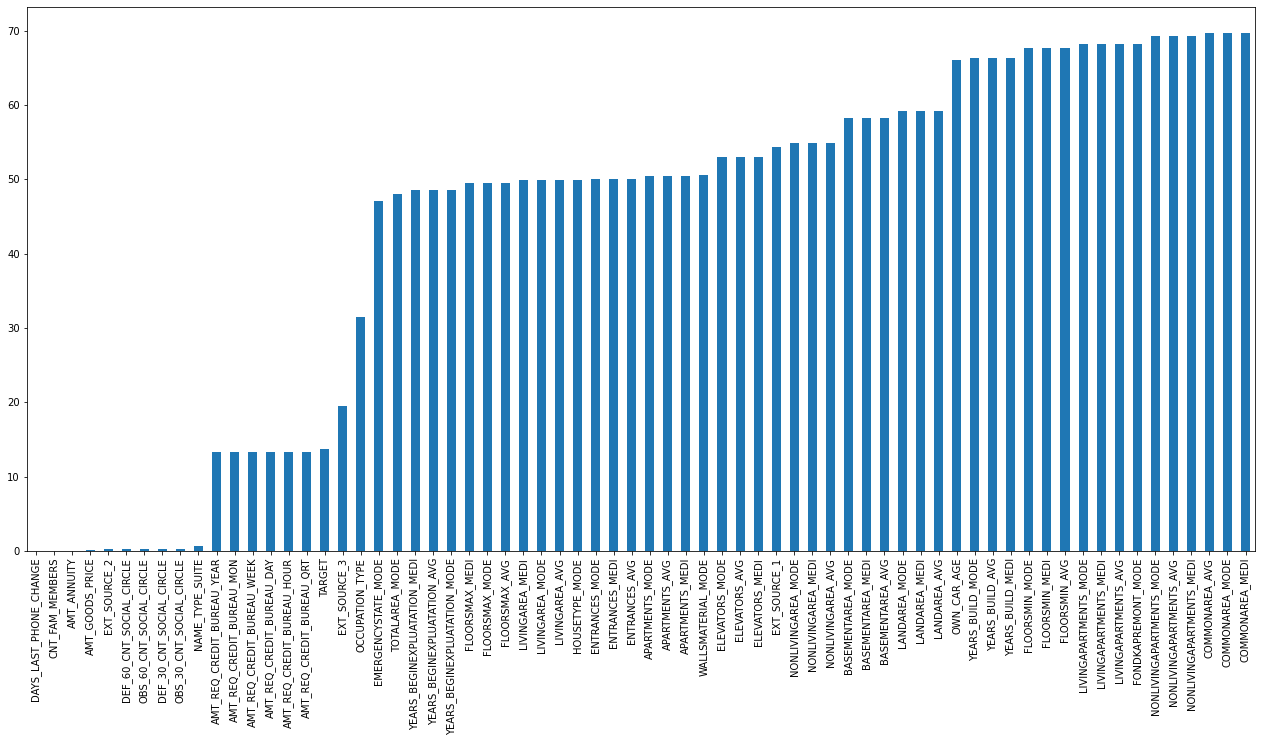

In [33]:
#Observation des pourcentages de valeurs manquantes par colonnes ayant des valeurs manquantes

nan_cols = [i for i in app.columns if app[i].isnull().any()]
percent_missing = app[nan_cols].isna().sum() * 100 / len(app)
plt.figure(figsize=(22, 10))
percent_missing.sort_values().plot(kind='bar')
plt.show()

### Variables catégorielles

In [34]:
def display_cat_columns(app):
    """
    Pour chaque colonne catégorielle, indique le nombre et le nom
    des différentes valeurs prises
    """

    for col in app:
        if app[col].dtype == object:
            print(col)
            print('Number Unique in Train:', app[~app['Test']][col].nunique())
            print('Number Unique in Test: ', app[app['Test']][col].nunique())
            print('Unique in Train: ',
                  sorted([str(e) for e in
                          app[~app['Test']][col].unique().tolist()]))
            print('Unique in Test: ',
                  sorted([str(e) for e in
                          app[app['Test']][col].unique().tolist()]))
            print('\n')

In [35]:
# Descriptif des variables catégorielles
display_cat_columns(app)

NAME_CONTRACT_TYPE
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['Cash loans', 'Revolving loans']
Unique in Test:  ['Cash loans', 'Revolving loans']


CODE_GENDER
Number Unique in Train: 3
Number Unique in Test:  2
Unique in Train:  ['F', 'M', 'XNA']
Unique in Test:  ['F', 'M']


FLAG_OWN_CAR
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


FLAG_OWN_REALTY
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


NAME_TYPE_SUITE
Number Unique in Train: 7
Number Unique in Test:  7
Unique in Train:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']
Unique in Test:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']


NAME_INCOME_TYPE
Number Unique in Train: 8
Number Unique in Test:  7
Unique in Train:  ['Businessman', 'Commercial associate

### Variable 'CODE_GENDER

Le jeu d'entrainement contient seulement 4 valeurs nommés 'XNA' pour la colonne renseignant le genre. Ces emprunts sont supprimés

In [36]:
# Supprime les individus dont le genre est 'XNA'
app = app[app['CODE_GENDER'] != 'XNA']

Variable 'NAME_INCOME_TYPE'

La colonne 'NAME_INCOME_TYPE' prend la valeur 'Maternity leave' uniquement pour le jeu d'entrainement , et pour seulement 5 emprunteurs. Les lignes renseignant ces emprunts sont supprimées

In [37]:
# Supprime les individus dont 'NAME_INCOME_TYPE' vient d'un congé maternité
app = app[app['NAME_INCOME_TYPE'] != 'Maternity leave']

Variable 'NAME_FAMILY_STATUS'

De la même manière, pour la colonne NAME_FAMILY_STATUS, il y a seulement deux fois la valeur Unknown et uniquement pour le jeu d'entrainement. Les lignes correspondantes sont supprimées

In [38]:
# Supprime les individus dont la statut familial est inconnu
app = app[app['NAME_FAMILY_STATUS'] != 'Unknown']

### Variables numériques

Variable 'DAYS_EMPLOYED'

350 000 jours ? C'est comme 1000 ans ! On dirait que toutes les valeurs raisonnables représentent le nombre de jours entre le moment où le demandeur a été employé et la date de la demande de prêt. Les valeurs déraisonnables sont toutes exactement 365 243 , nous allons donc les définir sur NaN.

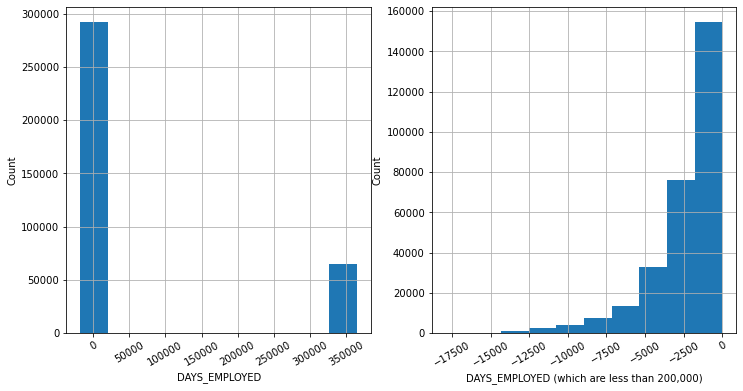

In [39]:
# Affiche l'histogramme du nombre de jours employés
fig = plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
app['DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.xticks(rotation=30)

# Affiche l'histogramme pour les valeurs normales
plt.subplot(1, 2, 2)
app.loc[app['DAYS_EMPLOYED'] < 200000, 'DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED (which are less than 200,000)')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

In [40]:
# Affiche les valeurs abérrantes
values_to_nan = app.loc[app['DAYS_EMPLOYED'] > 366, 'DAYS_EMPLOYED'].unique()
print(values_to_nan)

[365243]


In [41]:
# Remplace la valeur abérrante par NaN
app['DAYS_EMPLOYED'].replace(values_to_nan, np.nan, inplace=True)

In [39]:
# Sauvegarde des résultats
app.to_csv("app_no_encoded_no_featureengineering.csv")

## Analyse Exploratoire

In [42]:
### Création d'un Df incluant la variable Target pour analyse exploratoire

train_set

train_set.shape

(307511, 123)

#### Analyse variables catégorielles

Fonction représentation graphique
Fonction qui représente la distribution d'une variable du jeu de données, ainsi que le % de cette variable représentée par les prêts non remboursés (TARGET = 1)

In [31]:
def plot_stats(feature, df, label_rotation=False,horizontal_layout=True):
    
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Nombre de prêts': temp.values})

    # % représentée par prêts non remboursés pour chaque valeur de la catégorie
    cat_perc = df[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Nombre de prêts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('% représenté par des problèmes de remboursement', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

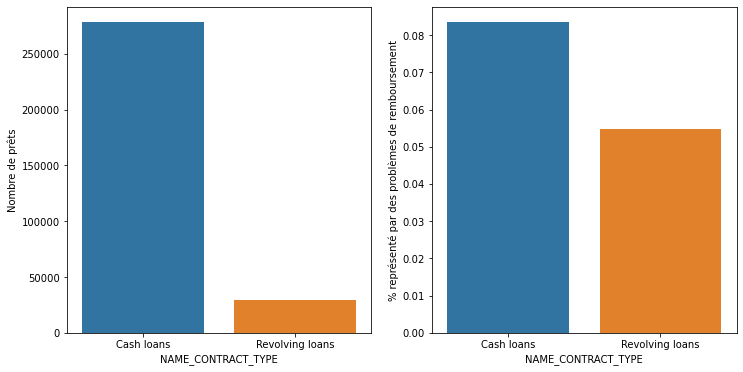

In [32]:

# Analyse des prêts par type

plot_stats('NAME_CONTRACT_TYPE', train_set)

Contract type Revolving loans are just a small fraction (10%) from the total number of loans; in the same time, a larger amount of Revolving loans, comparing with their frequency, are not repaid.

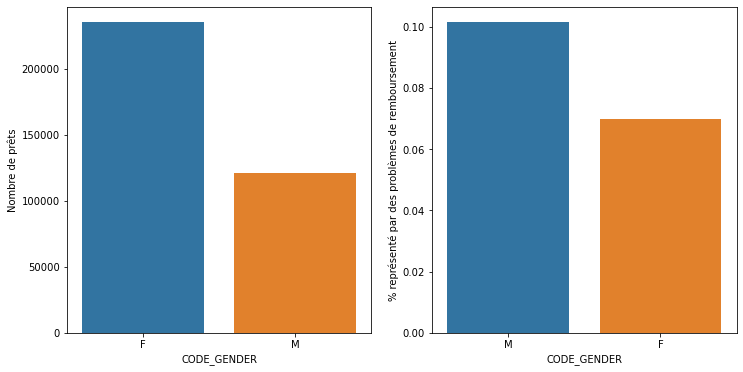

In [36]:
# Analyse des prêts par genre

plot_stats('CODE_GENDER', app)

The number of female clients is almost double the number of male clients. Looking to the percent of defaulted credits, males have a higher chance of not returning their loans (around 10%), comparing with women (around 7%).

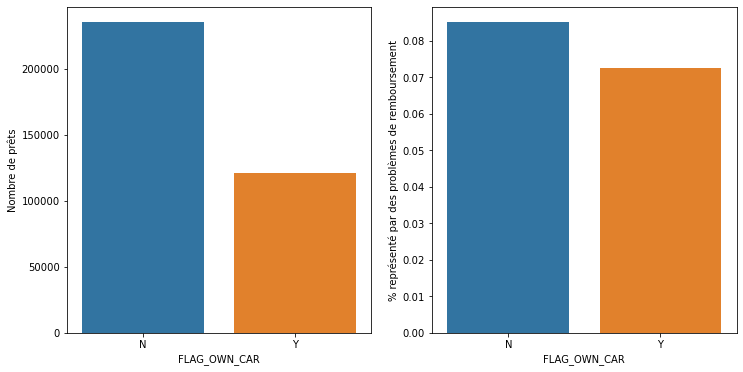

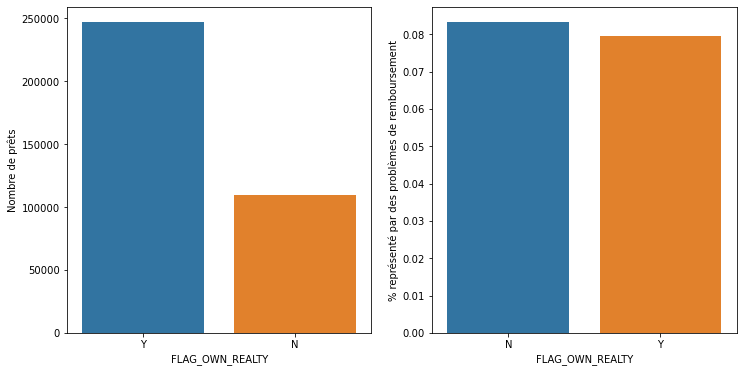

In [37]:
# Distribution en fonction de la possession d'une voiture ou d'un bien immobilier

plot_stats('FLAG_OWN_CAR', app)
plot_stats('FLAG_OWN_REALTY', app)

The clients that own a car are almost a half of the ones that don't own one. The clients that own a car are less likely to not repay a car that the ones that own. Both categories have not-repayment rates around 8%.

The clients that own real estate are more than double of the ones that don't own. Both categories (owning real estate or not owning) have not-repayment rates around 8%

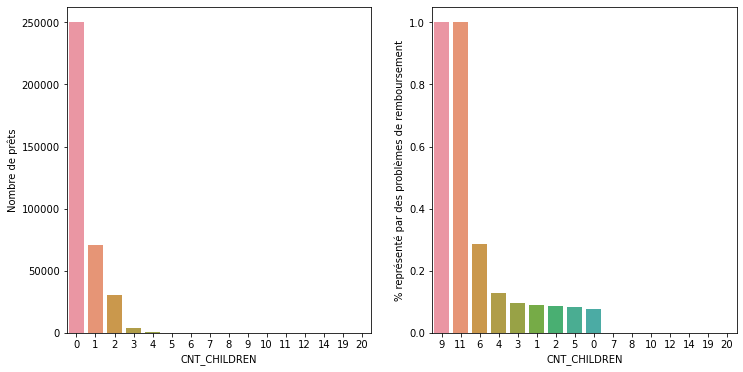

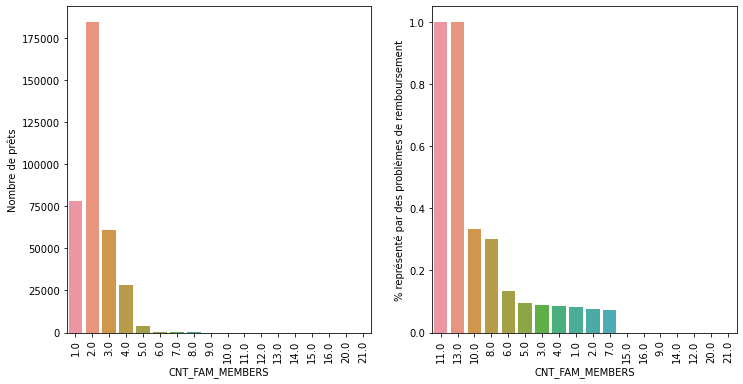

In [38]:
# Distribution en fonction du nombre d'enfants et de membres de la famille

plot_stats('CNT_CHILDREN', app)
plot_stats('CNT_FAM_MEMBERS', app, True, True)


Most of the clients taking a loan have no children. The number of loans associated with the clients with one children are 4 times smaller, the number of loans associated with the clients with two children are 8 times smaller; clients with 3, 4 or more children are much more rare.

As for repayment, clients with no children, 1, 2, 3, and 5 children have percents of no repayment around the average (10%). The clients with 4 and 6 children are above average in terms of percent of not paid back loans (over 25% for families with 6 children).

As for clients with 9 or 11 children, the percent of loans not repaid is 100%.

Clients with family members of 2 are most numerous, followed by 1 (single persons), 3 (families with one child) and 4.

Clients with family size of 11 and 13 have 100% not repayment rate. Other families with 10 or 8 members have percents of not repayment of loans over 30%. Families with 6 or less members have repayment rates close to the 10% average.

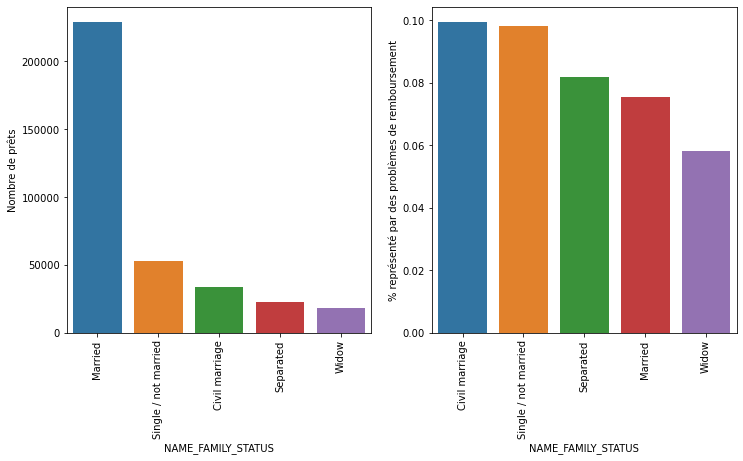

In [39]:
# Distribution en fonction du statut familial

plot_stats('NAME_FAMILY_STATUS', app, True, True)

Most of clients are married, followed by Single/not married and civil marriage.

In terms of percentage of not repayment of loan, Civil marriage has the highest percent of not repayment (10%), with Widow the lowest (exception being Unknown).

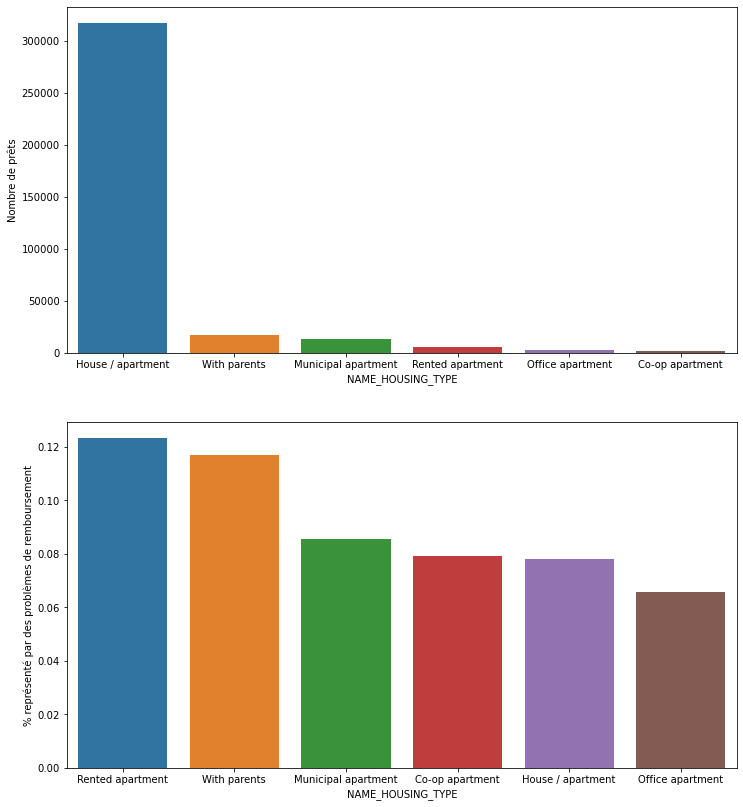

In [40]:
# Distribution en fonction du type de logement

plot_stats('NAME_HOUSING_TYPE', app, False, False)

Over 250,000 applicants for credits registered their housing as House/apartment. Following categories have a very small number of clients (With parents, Municipal appartment).

From these categories, Rented apartment and With parents have higher than 10% not-repayment rate.

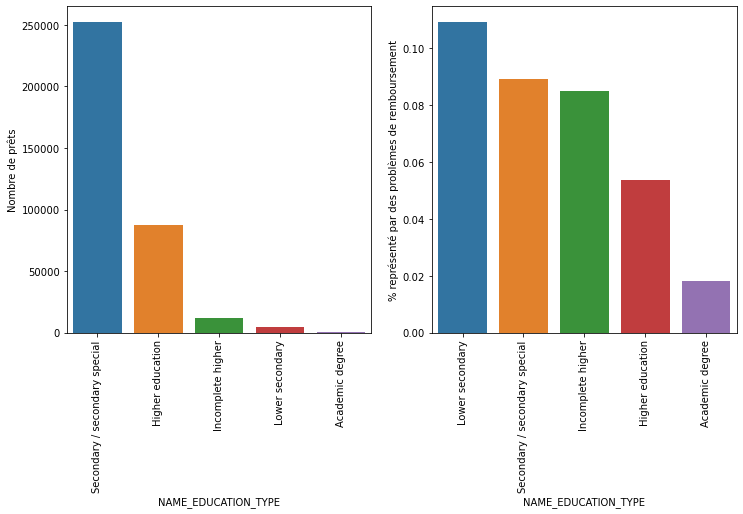

In [41]:
# Distribution en fonction du type d'éducation

plot_stats('NAME_EDUCATION_TYPE', app, True)

Majority of the clients have Secondary / secondary special education, followed by clients with Higher education. Only a very small number having an academic degree.

The Lower secondary category, although rare, have the largest rate of not returning the loan (11%). The people with Academic degree have less than 2% not-repayment rate.

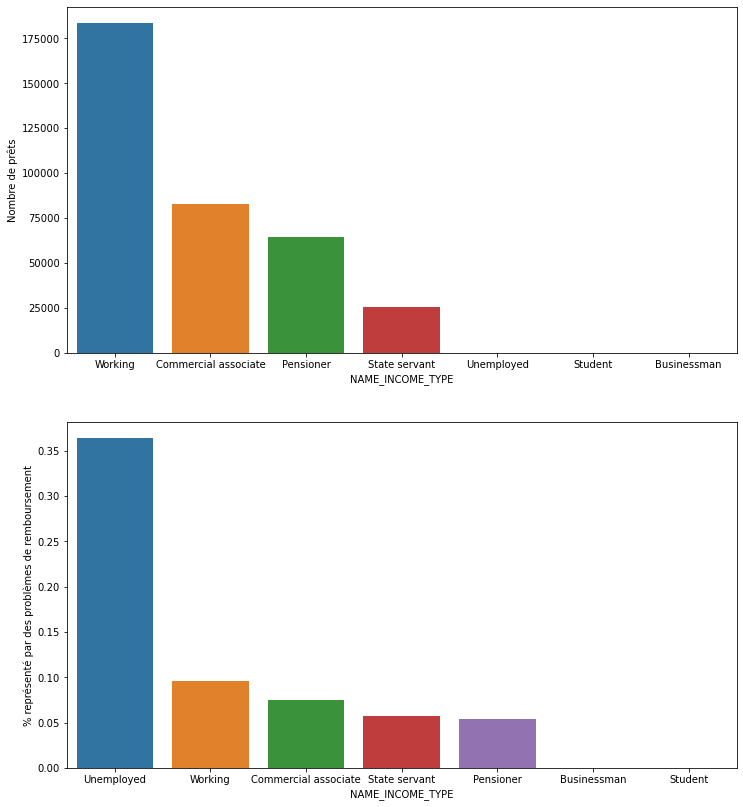

In [43]:
# Distribution en fonction du type de source de revenus du client

plot_stats('NAME_INCOME_TYPE', app, False, False)

Most of applicants for loans are income from Working, followed by Commercial associate, Pensioner and State servant.

The applicants with the type of income Maternity leave have almost 40% ratio of not returning loans, followed by Unemployed (36%). The rest of types of incomes are under the average of 10% for not returning loans.

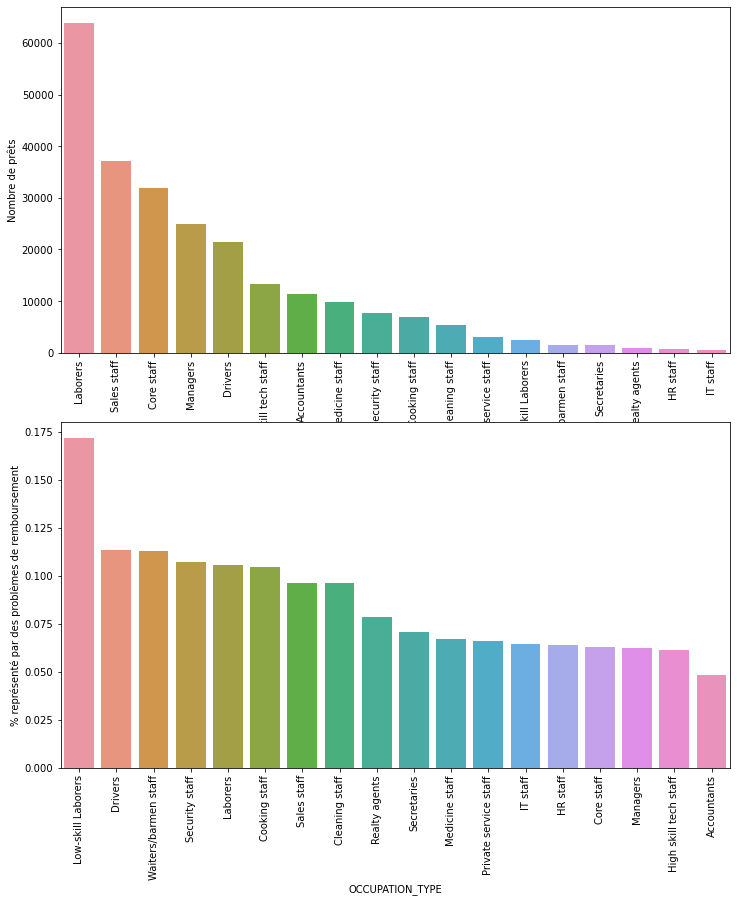

In [44]:
# Distribution en fonction du type d'activité pro du client

plot_stats('OCCUPATION_TYPE', app, True, False)

Most of the loans are taken by Laborers, followed by Sales staff. IT staff take the lowest amount of loans.

The category with highest percent of not repaid loans are Low-skill Laborers (above 17%), followed by Drivers and Waiters/barmen staff, Security staff and Cooking staff.

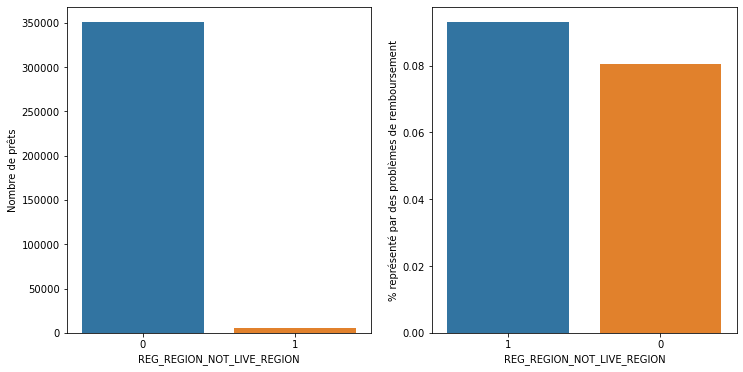

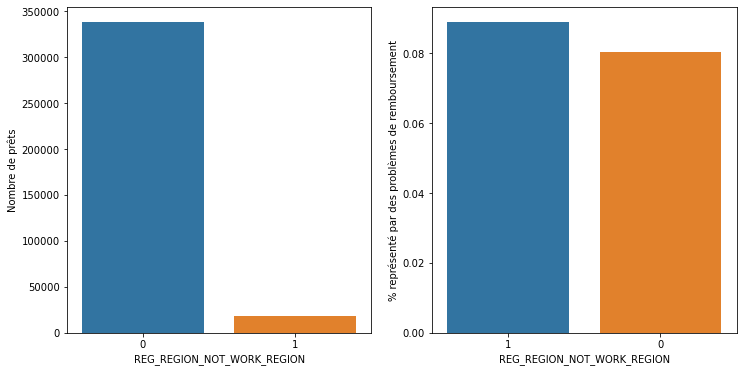

In [45]:
# Distribution en fonction de la région de résidence par rapport à la résidence du lieu de travail

plot_stats('REG_REGION_NOT_LIVE_REGION', app)
plot_stats('REG_REGION_NOT_WORK_REGION', app)


Very few people are registered in not live or not work region. Generally, the rate of not return is slightly larger for these cases than in the rest (slightly above 8% compared with approx. 8%)

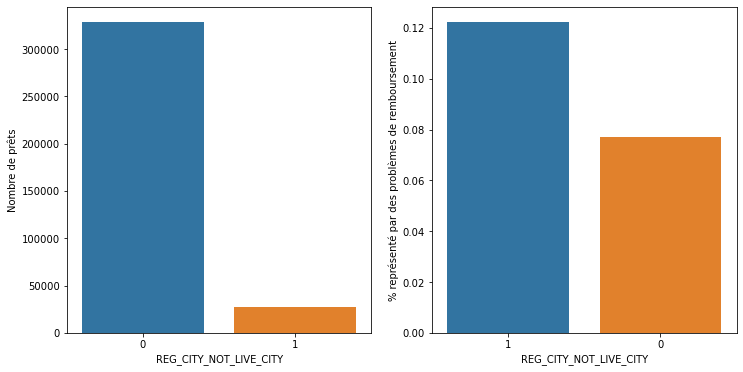

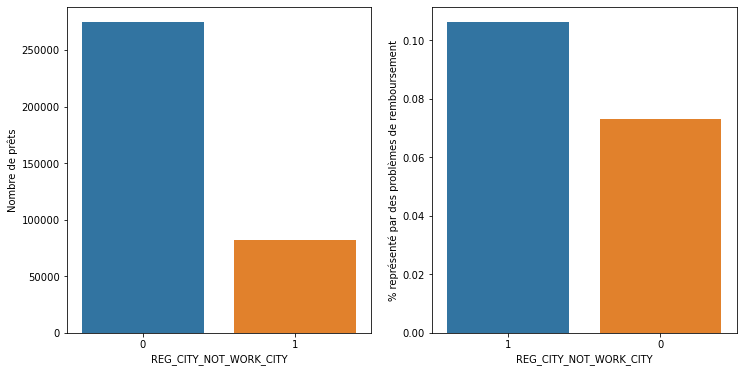

In [46]:
# Distribution en fonction de la ville de résidence par rapport à la ville du lieu de travail

plot_stats('REG_CITY_NOT_LIVE_CITY', app)
plot_stats('REG_CITY_NOT_WORK_CITY', app)

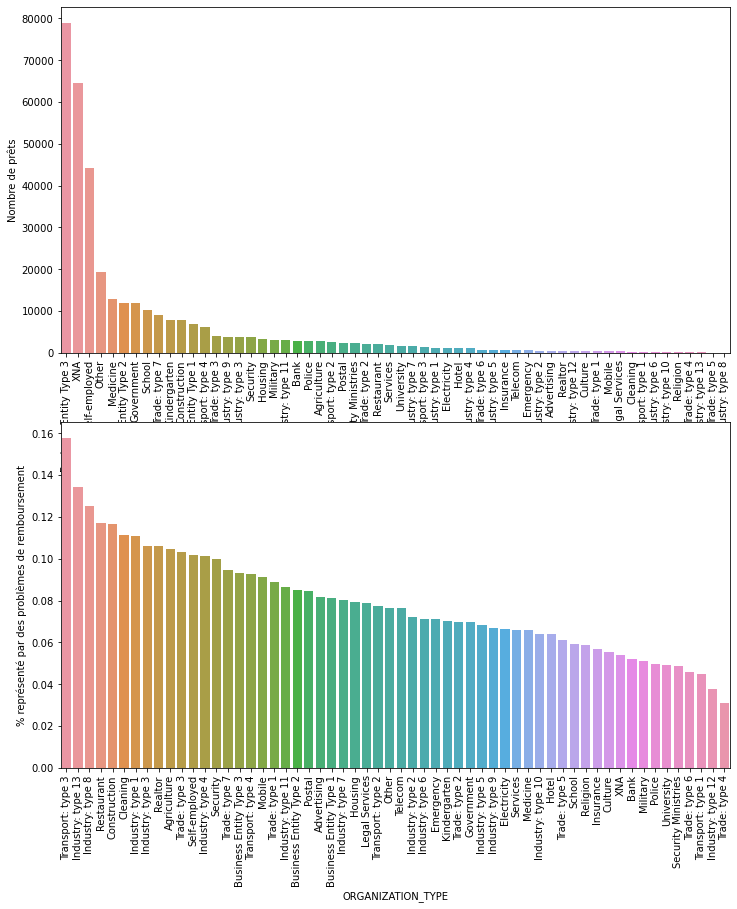

In [47]:
# Distribution en fonction de la ville de résidence par rapport à la ville du lieu de travail

plot_stats('ORGANIZATION_TYPE', app, True, False)

### Analyse variables quantitatives

Fonctions représentation graphique
Une fonction est créée pour superposer pour certaines variables les distributions correspondant à chaque catégorie de prêt (TARGET = 0 ou 1)

In [1]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(df, var, nrow=2):
    
    i = 0
    t1 = df.loc[df['TARGET'] != 0]
    t0 = df.loc[df['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(16,8*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.distplot(t1[feature],label="TARGET = 1", hist = False)
        sns.distplot(t0[feature],label="TARGET = 0", hist = False)
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

##### Analyse variables quantitatives

In [50]:
# Je vais d'abord convertir les données qui sont en nombres de jours en positif et en années 
# (sauf DAYS_EMPLOYED - voir ci-dessus)

col_yr = ['DAYS_BIRTH', 'DAYS_REGISTRATION','DAYS_ID_PUBLISH']

for c in col_yr:
    app[c] = - app[c] / 365

<Figure size 432x288 with 0 Axes>

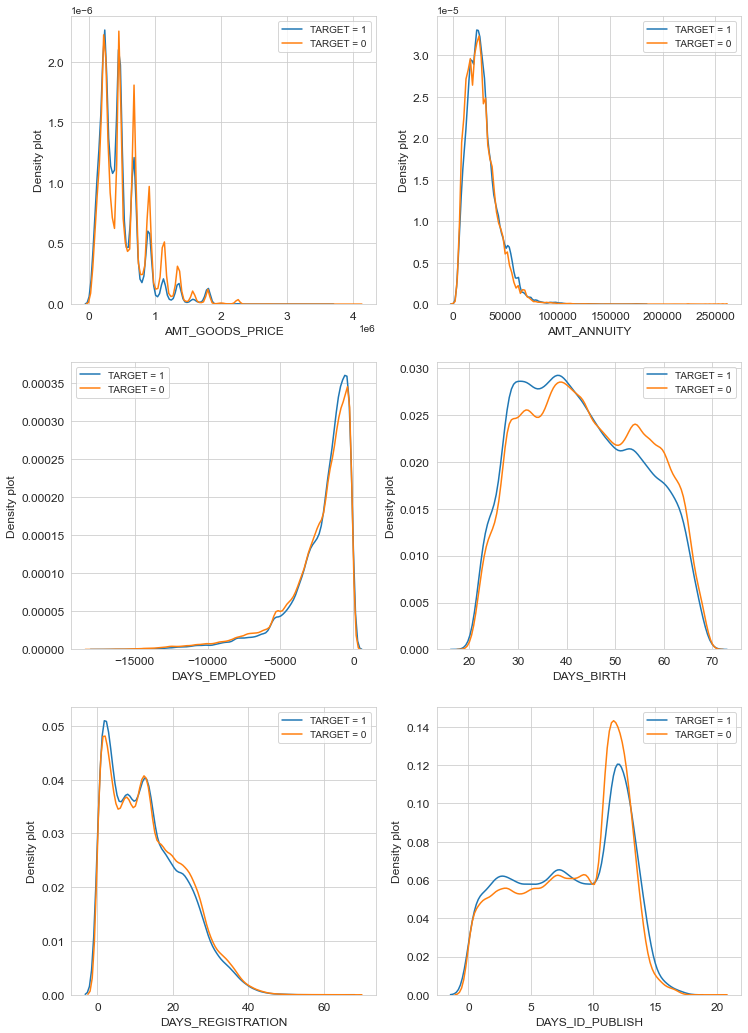

In [51]:
cols = ['AMT_GOODS_PRICE', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH']

plot_distribution_comp(app, cols, nrow = 3)

La principale observation concerne le nombre de jours où le client a été employé. On voit clairement que pour les prêts en défaut, ce nombre de jours est relativement faible alors que nous observons un pic pour les prêts remboursés parmi les retraités (personnes relativement aisées)

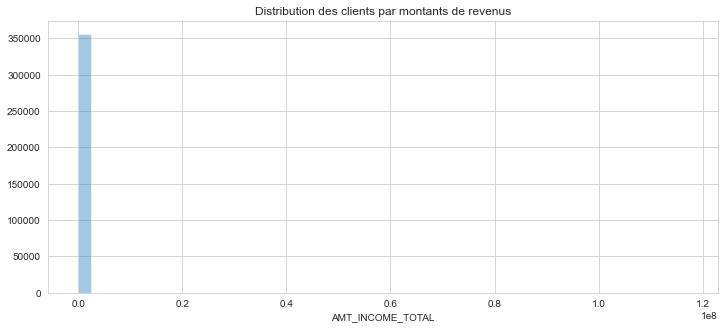

In [52]:
# Distribution des revenus des clients

plt.figure(figsize=(12,5))
plt.title("Distribution des clients par montants de revenus")
ax = sns.distplot(app['AMT_INCOME_TOTAL'], kde= False)

On peut voir que la distribution est fortement influencée par les valeurs extrêmes. Nous allons utiliser un boxplot en excluant les outliers

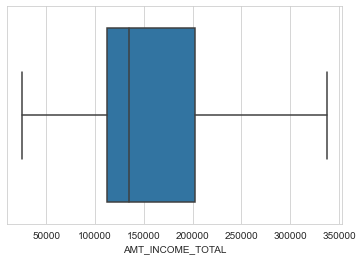

In [53]:
# Distribution pour les clients avec TARGET = 1

ax = sns.boxplot(x='AMT_INCOME_TOTAL', data=app[app.TARGET == 1], showfliers = False)

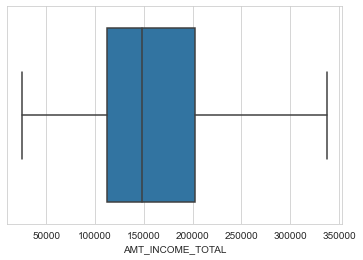

In [54]:
# Distribution pour les clients avec TARGET = 0

ax = sns.boxplot(x='AMT_INCOME_TOTAL', data=app[app.TARGET == 0], showfliers = False)

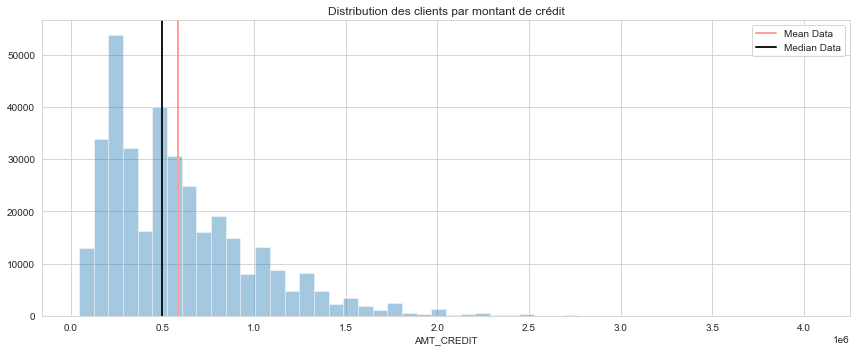

In [55]:
# Distribution des montants de crédit des clients

plt.figure(figsize=(12,5))
plt.title("Distribution des clients par montant de crédit")
ax = sns.distplot(app['AMT_CREDIT'], kde= False)
custom_lines = [plt.axvline(app['AMT_CREDIT'].mean(), color = 'r', linewidth = 2), 
               plt.axvline(app['AMT_CREDIT'].median(), color = 'k', linewidth = 2)]

plt.legend(custom_lines, ["Mean Data","Median Data"])

plt.tight_layout()
plt.show()

### Feature Engineering

Feature Engineering' automatisé 

In [35]:
# Create an entity set
es = ft.EntitySet(id='applications')

In [36]:
# Add dataframe to entityset
es = es.entity_from_dataframe(entity_id='applications',
                              dataframe=app,
                              index='SK_ID_CURR')

In [37]:
# Affiche le type de chaque colonne
es['applications']

Entity: applications
  Variables:
    SK_ID_CURR (dtype: index)
    TARGET (dtype: numeric)
    NAME_CONTRACT_TYPE (dtype: categorical)
    CODE_GENDER (dtype: categorical)
    FLAG_OWN_CAR (dtype: categorical)
    FLAG_OWN_REALTY (dtype: categorical)
    CNT_CHILDREN (dtype: numeric)
    AMT_INCOME_TOTAL (dtype: numeric)
    AMT_CREDIT (dtype: numeric)
    AMT_ANNUITY (dtype: numeric)
    AMT_GOODS_PRICE (dtype: numeric)
    NAME_TYPE_SUITE (dtype: categorical)
    NAME_INCOME_TYPE (dtype: categorical)
    NAME_EDUCATION_TYPE (dtype: categorical)
    NAME_FAMILY_STATUS (dtype: categorical)
    NAME_HOUSING_TYPE (dtype: categorical)
    REGION_POPULATION_RELATIVE (dtype: numeric)
    DAYS_BIRTH (dtype: numeric)
    DAYS_EMPLOYED (dtype: numeric)
    DAYS_REGISTRATION (dtype: numeric)
    DAYS_ID_PUBLISH (dtype: numeric)
    OWN_CAR_AGE (dtype: numeric)
    FLAG_MOBIL (dtype: numeric)
    FLAG_EMP_PHONE (dtype: numeric)
    FLAG_WORK_PHONE (dtype: numeric)
    FLAG_CONT_MOBILE (dtype: n

Certaines variables sont de type 'numeric' alors qu'elles devraient être de type 'boolean'.

Les types sont changés manuellement via le package FeatureTools

In [38]:
# Featuretools datatypes
BOOL = ft.variable_types.Boolean

# Manually define datatypes in app dataframe
variable_types = {
    'FLAG_MOBIL': BOOL,
    'FLAG_EMP_PHONE': BOOL,
    'FLAG_WORK_PHONE': BOOL,
    'FLAG_CONT_MOBILE': BOOL,
    'FLAG_PHONE': BOOL,
    'FLAG_EMAIL': BOOL,
    'REG_REGION_NOT_LIVE_REGION': BOOL,
    'REG_REGION_NOT_WORK_REGION': BOOL,
    'LIVE_REGION_NOT_WORK_REGION': BOOL,
    'REG_CITY_NOT_LIVE_CITY': BOOL,
    'REG_CITY_NOT_WORK_CITY': BOOL,
    'LIVE_CITY_NOT_WORK_CITY': BOOL,
    'FLAG_DOCUMENT_2': BOOL,
    'FLAG_DOCUMENT_3': BOOL,
    'FLAG_DOCUMENT_4': BOOL,
    'FLAG_DOCUMENT_5': BOOL,
    'FLAG_DOCUMENT_6': BOOL,
    'FLAG_DOCUMENT_7': BOOL,
    'FLAG_DOCUMENT_8': BOOL,
    'FLAG_DOCUMENT_9': BOOL,
    'FLAG_DOCUMENT_10': BOOL,
    'FLAG_DOCUMENT_11': BOOL,
    'FLAG_DOCUMENT_12': BOOL,
    'FLAG_DOCUMENT_13': BOOL,
    'FLAG_DOCUMENT_14': BOOL,
    'FLAG_DOCUMENT_15': BOOL,
    'FLAG_DOCUMENT_16': BOOL,
    'FLAG_DOCUMENT_17': BOOL,
    'FLAG_DOCUMENT_18': BOOL,
    'FLAG_DOCUMENT_19': BOOL,
    'FLAG_DOCUMENT_20': BOOL,
    'FLAG_DOCUMENT_21': BOOL,
}

# Add dataframe to entityset, using manual datatypes
es = es.entity_from_dataframe(entity_id='applications',
                              dataframe= app,
                              index='SK_ID_CURR',
                              variable_types=variable_types)

In [39]:
# Affiche le type de chaque colonne
es['applications']

Entity: applications
  Variables:
    SK_ID_CURR (dtype: index)
    TARGET (dtype: numeric)
    NAME_CONTRACT_TYPE (dtype: categorical)
    CODE_GENDER (dtype: categorical)
    FLAG_OWN_CAR (dtype: categorical)
    FLAG_OWN_REALTY (dtype: categorical)
    CNT_CHILDREN (dtype: numeric)
    AMT_INCOME_TOTAL (dtype: numeric)
    AMT_CREDIT (dtype: numeric)
    AMT_ANNUITY (dtype: numeric)
    AMT_GOODS_PRICE (dtype: numeric)
    NAME_TYPE_SUITE (dtype: categorical)
    NAME_INCOME_TYPE (dtype: categorical)
    NAME_EDUCATION_TYPE (dtype: categorical)
    NAME_FAMILY_STATUS (dtype: categorical)
    NAME_HOUSING_TYPE (dtype: categorical)
    REGION_POPULATION_RELATIVE (dtype: numeric)
    DAYS_BIRTH (dtype: numeric)
    DAYS_EMPLOYED (dtype: numeric)
    DAYS_REGISTRATION (dtype: numeric)
    DAYS_ID_PUBLISH (dtype: numeric)
    OWN_CAR_AGE (dtype: numeric)
    OCCUPATION_TYPE (dtype: categorical)
    CNT_FAM_MEMBERS (dtype: numeric)
    REGION_RATING_CLIENT (dtype: numeric)
    REGION_RATI

In [40]:
# Featuretools datatypes
BOOL = ft.variable_types.Boolean
ID = ft.variable_types.Id

# Add bureau dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='bureau',
    dataframe=bureau,
    index='SK_ID_BUREAU',
    variable_types={'SK_ID_CURR': ID})

# Add bureau_balance dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='bureau_balance',
    dataframe=bureau_balance,
    index='New',
    variable_types={'SK_ID_BUREAU': ID})

# Add cash_balance dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='cash_balance',
    dataframe=cash_balance,
    index='New',
    variable_types={'SK_ID_PREV': ID,
                    'SK_ID_CURR': ID})

# Add card_balance dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='card_balance',
    dataframe=card_balance,
    index='New',
    variable_types={'SK_ID_PREV': ID,
                    'SK_ID_CURR': ID})

# Add prev_app dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='prev_app',
    dataframe=prev_app,
    index='SK_ID_PREV',
    variable_types={'SK_ID_CURR': ID,
                    'NFLAG_LAST_APPL_IN_DAY': BOOL})

# Add payments dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='payments',
    dataframe=payments,
    index='New',
    variable_types={'SK_ID_PREV': ID,
                    'SK_ID_CURR': ID})

C:\Users\viault\anaconda3\lib\site-packages\featuretools\entityset\entity.py:462: UserWarning: index New not found in dataframe, creating new integer column
  warnings.warn("index {} not found in dataframe, creating new "


NameError: name 'card_balance' is not defined

In [ ]:
# Define relationships between dataframes
relationships = [
  # parent_entity   parent_variable  child_entity      child_variable
  ('applications', 'SK_ID_CURR',    'bureau',         'SK_ID_CURR'),
  ('bureau',       'SK_ID_BUREAU',  'bureau_balance', 'SK_ID_BUREAU'),
  ('applications', 'SK_ID_CURR',    'prev_app',       'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'cash_balance',   'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'payments',       'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'card_balance',   'SK_ID_CURR')
]

# Create the relationships
for pe, pv, ce, cv in relationships:
    es = es.add_relationship(ft.Relationship(es[pe][pv], es[ce][cv]))

In [ ]:
# Define which primitives to use
agg_primitives =  ['count', 'median'] #, 'min', 'max']
trans_primitives = ['cum_sum']

In [36]:
# Run deep feature synthesis
app, features = ft.dfs(entityset=es,
                       target_entity='applications',
                       trans_primitives=trans_primitives,
                       agg_primitives=agg_primitives, 
                       verbose=True,
                       max_depth=2)

Built 406 features
Elapsed: 03:36 | Progress:   2%|▏         


MemoryError: Unable to allocate 1.44 GiB for an array with shape (8, 24179741) and data type float64

In [41]:
# Liste de toutes les variables
app.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [42]:
# Remove low information features
app = selection.remove_low_information_features(app)
print("Le nombre de colonnes est de {}".format(len(app.columns)))

Le nombre de colonnes est de 123


### Feature Engineering manuel 

Cette étape de 'Feature Engineering' permet de créer de nouvelles features pertinentes issues de celles existantes pour aider le modèle :

1/ Le ratio temps travaillé/âge : la création d'une variable faisant le ratio entre la durée d'emploi et l'age du client.

2/ Le ratio crédit/revenu : omme les variables AMT_INCOME_TOTAL et 'AMT_CREDIT' sont très dispersées et influencées par des valeurs extrêmes, je vais créer une variable étant le ratio entre les 2 variables afin de voir la distribution de cette nouvelle variable

3/ le ratio revenu/annuité

4/ le ratio revenu/annuité/âge

5/ le ratio crédit/annuité : Je vais désormais créer une variable représentant la durée du crédit en années comme le rapport entre le montant total du crédit et les remboursements annuels (annuity)

6/ le ratio crédit/annuité/âge

In [61]:
def manual_feature_engineering(app) :
    
    #Certaines compositions pertinentes de variables permettent d'aider le modèle
    
    app['PROPORTION_LIFE_EMPLOYED'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']
    app['INCOME_TO_CREDIT_RATIO'] = app['AMT_INCOME_TOTAL'] / app['AMT_CREDIT'] 
    app['INCOME_TO_ANNUITY_RATIO'] = app['AMT_INCOME_TOTAL'] / app['AMT_ANNUITY']
    app['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = app['INCOME_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']
    app['CREDIT_TO_ANNUITY_RATIO'] = app['AMT_CREDIT'] / app['AMT_ANNUITY']
    app['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = app['CREDIT_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']
    app['INCOME_TO_FAMILYSIZE_RATIO'] = app['AMT_INCOME_TOTAL'] / app['CNT_FAM_MEMBERS']
    
    return app

In [62]:
# Feature engineering manuel
app = manual_feature_engineering(app)

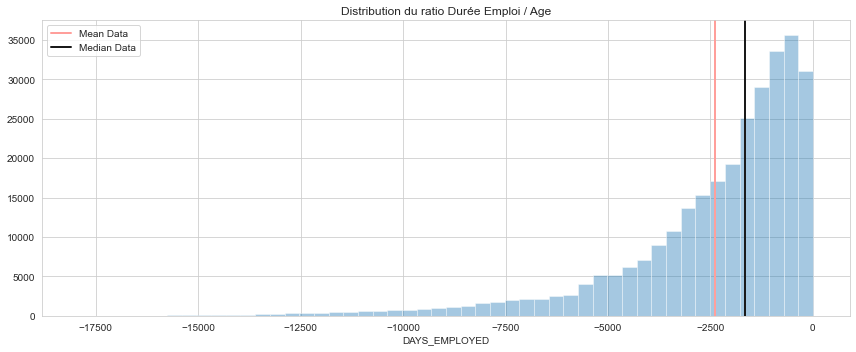

In [58]:
plt.figure(figsize=(12,5))
plt.title("Distribution du ratio Durée Emploi / Age")
ax = sns.distplot(app["DAYS_EMPLOYED"], kde= False)
custom_lines = [plt.axvline(app["DAYS_EMPLOYED"].mean(), color = 'r', linewidth = 2), 
               plt.axvline(app["DAYS_EMPLOYED"].median(), color = 'k', linewidth = 2)]

plt.legend(custom_lines, ["Mean Data","Median Data"])

plt.tight_layout()
plt.show()

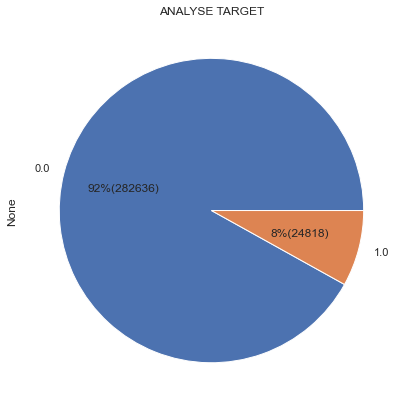

In [65]:
variable = app[app["INCOME_TO_ANNUITY_RATIO"]>1].groupby("TARGET").size()

sns.set()
variable.plot(kind='pie', 
              title='ANALYSE TARGET', 
              figsize=[7,7],
              autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*variable.sum()))
plt.show()


Seulement 8% de ces clients ont fait défaut, ce qui est certes au dessus de la moyenne mais contre-intuitif. On peut imaginer que le prêt a été remboursé via d'autres crédits, ou par la vente du bien

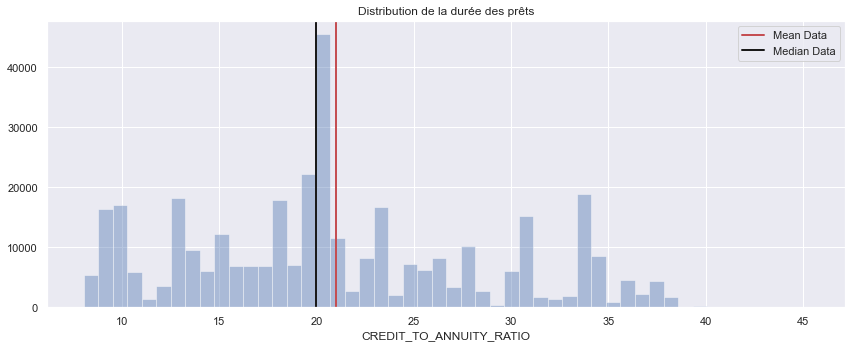

In [66]:
# Distribution de la durée des prêts

plt.figure(figsize=(12,5))
plt.title("Distribution de la durée des prêts")
ax = sns.distplot(app["CREDIT_TO_ANNUITY_RATIO"], kde= False)
custom_lines = [plt.axvline(app["CREDIT_TO_ANNUITY_RATIO"].mean(), color = 'r', linewidth = 2), 
               plt.axvline(app["CREDIT_TO_ANNUITY_RATIO"].median(), color = 'k', linewidth = 2)]

plt.legend(custom_lines, ["Mean Data","Median Data"])

plt.tight_layout()
plt.show()

La majorité des prêts se retrouve autour de 20 ans, avec un certain nombres de prêts au dela de 30 ans. Il serait intéressant de regarder la distribution de ces prêts afin de voir s'il n'y a pas un lien avec les défauts de paiement.

Passons ensuite à la création d'une variable faisant le ratio entre la durée d'emploi et l'age du client.

In [45]:
# Sauvegarde des résultats
app.to_csv("app_no_enconded_featureengineering.csv")

### Données manquantes

In [46]:
def missing_values(df, display=False, printf=True, top_n_missing=30, title=""): 
    
    # Calcul de la proportion de données manquantes pour chaque colonne

    null_prop = df.isnull().sum(axis=0).sum()/len(df)/len(df.columns)*100
    null = df.isnull().sum(axis=0).sort_values()/len(df)*100
    
    if printf:
        print("Le pourcentage moyen de valeurs manquantes est de {:.2f}%".format(null_prop))
    
    # Si display=True, plot :
    if display :
        fig = plt.figure(figsize=(14, 6))
        plt.axhline(y=null_prop, color='k', linestyle='--', lw=2)
        plt.legend(['{:.2f}% global de données manquantes'.format(null_prop)], fontsize=13)

        data_to_plot = pd.DataFrame(null).sort_values(by = 0, ascending=False)[0: top_n_missing]
        
        sns.barplot(data_to_plot.index, data_to_plot[0])
        plt.ylabel("%")
        plt.title(title)
        labels = ['\n'.join(wrap(l, top_n_missing)) for l in data_to_plot.index]        
        plt.xticks(range(len(labels)), labels, rotation='vertical')
        
        plt.show()
    else :
        return null

In [47]:
# On récupère les données d'entrainement
train_set = app[app['Test'] == False]
# On r"cupère les données test
test_set = app[app['Test'] == True]

In [48]:
missing_values(train_set,
               display=False,
               title="Pourcentage de valeurs manquantes pour le jeu d'entrainement")

Le pourcentage moyen de valeurs manquantes est de 23.17%


SK_ID_CURR                      0.000000
REG_REGION_NOT_LIVE_REGION      0.000000
REG_REGION_NOT_WORK_REGION      0.000000
LIVE_REGION_NOT_WORK_REGION     0.000000
REG_CITY_NOT_LIVE_CITY          0.000000
                                 ...    
NONLIVINGAPARTMENTS_MODE       69.432846
NONLIVINGAPARTMENTS_MEDI       69.432846
COMMONAREA_MEDI                69.871870
COMMONAREA_AVG                 69.871870
COMMONAREA_MODE                69.871870
Length: 130, dtype: float64

In [49]:
missing_values(test_set,
               display=False,
               title="Pourcentage de valeurs manquantes pour le jeu test")

Le pourcentage moyen de valeurs manquantes est de 23.23%


SK_ID_CURR                       0.000000
REG_REGION_NOT_WORK_REGION       0.000000
LIVE_REGION_NOT_WORK_REGION      0.000000
REG_CITY_NOT_LIVE_CITY           0.000000
REG_CITY_NOT_WORK_CITY           0.000000
                                  ...    
NONLIVINGAPARTMENTS_MODE        68.412523
COMMONAREA_AVG                  68.716150
COMMONAREA_MODE                 68.716150
COMMONAREA_MEDI                 68.716150
TARGET                         100.000000
Length: 130, dtype: float64

### Suppression des valeurs manquantes

Les colonnes dont les valeurs manquantes sont supérieurs à 90 % sont supprimés des données

In [50]:
def drop_missing_values(app):

    # On récupère les données d'entrainement
    train_set = app[app['Test'] == False]
    # On r"cupère les données test
    test_set = app[app['Test'] == False]
    
    # Détermine la proportion de valeurs manquantes pour les données d'entrainement
    missing_train = missing_values(train_set, printf=False)
    # Détermine la proportion de valeurs manquantes pour les données test
    missing_test = missing_values(test_set, printf=False)
    
    # Défini la liste des variables dont les valeurs manquantes sont supérieurs à 10%
    # Jeu d'entrainement
    var_missing_values_train = list(missing_train[missing_train > 90].index)
    # Jeu test
    var_missing_values_test = list(missing_test[missing_test > 90].index)
    # Concaténation des variables + suppression des doublons
    var_missing_values = list(set(var_missing_values_train + var_missing_values_test))
    
    # Suppression des colomnes dont les valeurs sont manquantes
    app.drop(columns=var_missing_values, inplace=True)
    
    # Affiche le nouveau pourcentage de valeurs manquantes
    null_prop = app.isnull().sum(axis=0).sum()/len(app)/len(app.columns)*100

    print('Le nouveau pourcentage de valeurs manquantes est de {:.2f}%'.format(null_prop))
    return app

In [51]:
app = drop_missing_values(app)

Le nouveau pourcentage de valeurs manquantes est de 23.18%


### Encodage des variables catégorielles 

Les variables catégorielles doivent être encodés pour être utilisables par les modèles. Les variables cycliques comme les jours de la semaine sont encodées en deux dimensions, les variables contenant uniquement 2 classes sont assignées à des 0 ou et des 1. Pour les variables à plus de 2 classes, un one-hot encoding est appliqué.

Encondage des 'variables temporelles' 

La colomne 'WEEKDAY_APPR_PROCESS_START' contient des informations catégorielles concernant le jour de la semaine. Une manière communément utilisée en ML est d'encoder la variable en deux dimensions en utilisant un système de coordonnées polaires. Les jours de la semaine sont alors représentés sur un cercle et le nombre de dimensions est réduit par rapport à un one-hot-encoding.

In [52]:
def polar_projection(app, col):

    # Create map from categories to polar projection
    DOW_map = {
        'MONDAY':    0,
        'TUESDAY':   1,
        'WEDNESDAY': 2,
        'THURSDAY':  3,
        'FRIDAY':    4,
        'SATURDAY':  5,
        'SUNDAY':    6,
    }
    DOW_map1 = {k: np.cos(2*np.pi*v/7.0) for k, v in DOW_map.items()}
    DOW_map2 = {k: np.sin(2*np.pi*v/7.0) for k, v in DOW_map.items()}

    # Show encoding of days of week -> circle
    days = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']
    tt = np.linspace(0, 2*np.pi, 200)
    xx = np.cos(tt)
    yy = np.sin(tt)
    plt.plot(xx, yy)
    plt.gca().axis('equal')
    plt.xlabel('Encoded Dimension 1')
    plt.ylabel('Encoded Dimension 2')
    plt.title('2D Projection of days of the week')
    for day in days:
        plt.text(DOW_map1[day], DOW_map2[day], day, ha='center')
    plt.show()
    
    # WEEKDAY_APPR_PROCESS_START to polar coords
    app[col + '_1'] = app[col].map(DOW_map1)
    app[col + '_2'] = app[col].map(DOW_map2)
    app.drop(columns=col, inplace=True)
    
    return app

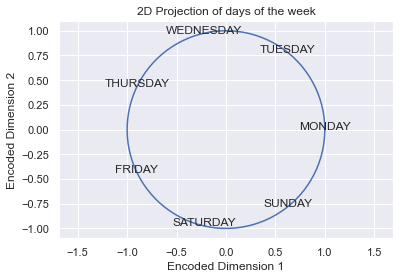

In [53]:
app = polar_projection(app, col='WEEKDAY_APPR_PROCESS_START')

Cet encodage conserve le caractère cyclique des jours de la semaine, tout en limitant le nombre de dimensions.

### Encodage des autres variables catégorielles 

For the housing-related features (e.g. LIVINGAPARTMENTS_MODE, BASEMENTAREA_AVG, etc) there are combinations of some PREFIX (e.g. LIVINGAPARTMENTS, BASEMENTAREA, etc) and some POSTFIX (e.g. MODE, MEDI, AVG, etc) into a variable PREFIX_POSTFIX. However, if one value for a given PREFIX is empty, the other values for that PREFIX will also be empty.

For each column which has some empty values, we want to add an indicator column which is 1 if the value in the corresponding column is empty, and 0 otherwise. However, if we do this with the housing-related features, we'll end up with a bunch of duplicate columns! This is because the same samples have null values across all the POSTFIX columns for a given PREFIX. The same problem crops up with the CREDIT_BUREAU-related features. To handle this problem, after creating the null indicator columns, we'll check for duplicate columns and merge them.

So, first we'll add columns to indicate where there are empty values in each other column.

Then we can label encode categorical features with only 2 possible values (that is, turn the labels into either 0 or 1).

Then we'll one-hot encode the categorical features which have more than 2 possible values.

In [54]:
def cat_encoder(app):
    
    """
    Encode les variables catégorielles avec un label encoder ou un one hot encoding suivant
    le nombre de valeurs différentes prises par chaque variable    
    """

    # Label encoder
    label_encoder = LabelEncoder()
    
    # categorials features to one hot encode
    cat_features = []
    col_to_del = []
    
    for col in app: 
        print(col)
        if col != 'Test' and col != 'TARGET':
            if app[col].dtype == object: 
                # Label encode binary fearures in training set
                if app[col].nunique() == 2:
                    app[col] = label_encoder.fit_transform(app[col])
                # get colunms to one hot encode
                elif app[col].nunique() > 2:
                    cat_features.append(col)

    # One-hot encode categorical features in train set
    app = pd.get_dummies(app, columns=cat_features)
       
    return app

In [55]:
def cat_encoder(app):
    
    """
    Encode les variables catégorielles avec un label encoder ou un one hot encoding suivant
    le nombre de valeurs différentes prises par chaque variable    
    """

    # Label encoder
    label_encoder = LabelEncoder()
    
    # categorials features to one hot encode
    cat_features = []
    col_to_del = []
    
    for col in app: 
        if col != 'Test' and col != 'TARGET':
            # Add indicator columns for empty values
            app_null = app[col].isnull()
            if app_null.sum() > 0:
                app[col + '_ISNULL'] = app_null
                col_to_del.append(col + '_ISNULL')

            if app[col].dtype == object: 
                # Label encode binary fearures in training set
                if app[col].nunique() == 2:
                    if col + '_ISNULL' in app.columns:  # missing values here?
                        app.loc[app[col + '_ISNULL'], col] = 'NaN'
                    app[col] = label_encoder.fit_transform(app[col])
                    if col + '_ISNULL' in app.columns:  # re-remove missing vals
                        app.loc[app[col + '_ISNULL'], col] = np.nan
                # get colunms to one hot encode
                elif app[col].nunique() > 2:
                    cat_features.append(col)

    # One-hot encode categorical features in train set
    app = pd.get_dummies(app, columns=cat_features)
    
    # Suppresion des colonnes nulles          
    app.drop(columns=col_to_del, inplace=True)
    
    return app

In [56]:
# Encondage des variables catégorielles
app = cat_encoder(app)

#### Sauvegarde des données pré-traités en fichier csv

In [57]:
# Sauvegarde des données
app.to_csv("app_encoded.csv")